In [1]:
# Check GPU
!nvidia-smi || echo "No GPU found. You can still run on CPU, but it will be slow."

# Install deps
!pip -q install --upgrade diffusers transformers accelerate torch torchvision torchaudio safetensors pillow


/bin/bash: line 1: nvidia-smi: command not found
No GPU found. You can still run on CPU, but it will be slow.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 86.0 MB/s eta 0:00:00


In [2]:
import torch
from diffusers import StableDiffusionPipeline

device = "cuda" if torch.cuda.is_available() else "cpu"

# You can switch to another public model id if you like.
model_id = "runwayml/stable-diffusion-v1-5"

pipe = StableDiffusionPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16 if device == "cuda" else torch.float32,
    safety_checker=None,            # disable HF safety checker (still follow local laws/content rules)
    use_safetensors=True
)

# Speed/VRAM tweaks
if device == "cuda":
    pipe = pipe.to("cuda")
    pipe.enable_xformers_memory_efficient_attention()
    pipe.enable_model_cpu_offload()  # ok to keep; it will manage VRAM better
else:
    pipe = pipe.to("cpu")

print(f"Ready on: {device}")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


Ready on: cpu


  0%|          | 0/30 [00:00<?, ?it/s]

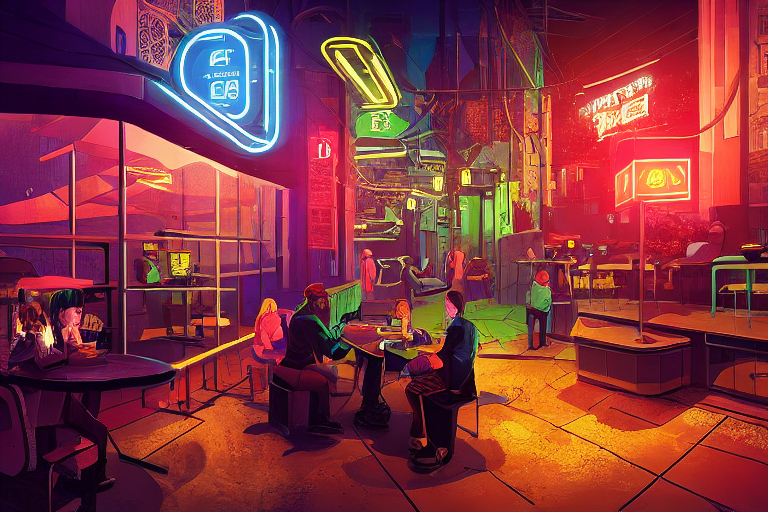

Saved to: /content/outputs/sd15_1755765599.png


In [3]:
from PIL import Image
import os, time

os.makedirs("/content/outputs", exist_ok=True)

prompt = "a cozy cyberpunk cafe at night, neon reflections, cinematic lighting, ultra-detailed"
negative_prompt = "low quality, blurry, deformed, watermark, text"
seed = 12345
guidance_scale = 7.5
steps = 30
width, height = 768, 512

generator = torch.Generator(device=device).manual_seed(seed)

image = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=steps,
    guidance_scale=guidance_scale,
    width=width,
    height=height,
    generator=generator
).images[0]

ts = int(time.time())
save_path = f"/content/outputs/sd15_{ts}.png"
image.save(save_path)
display(image)
print("Saved to:", save_path)


  0%|          | 0/30 [00:00<?, ?it/s]

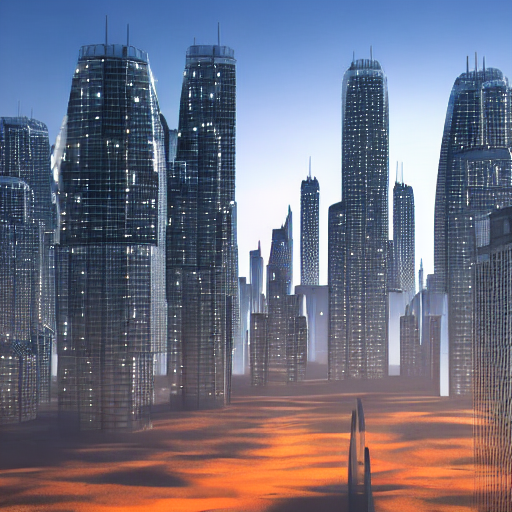

Saved: /content/outputs/batch_0.png


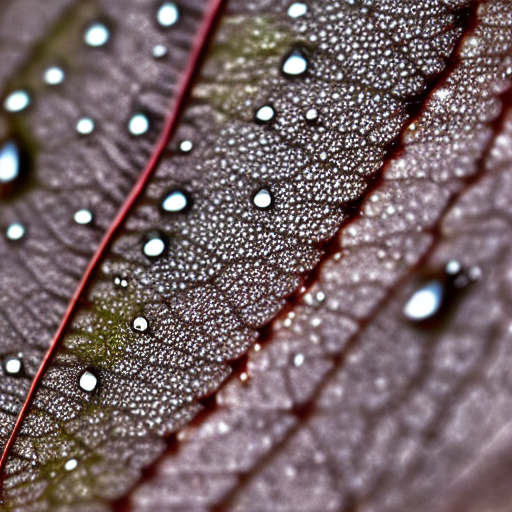

Saved: /content/outputs/batch_1.png


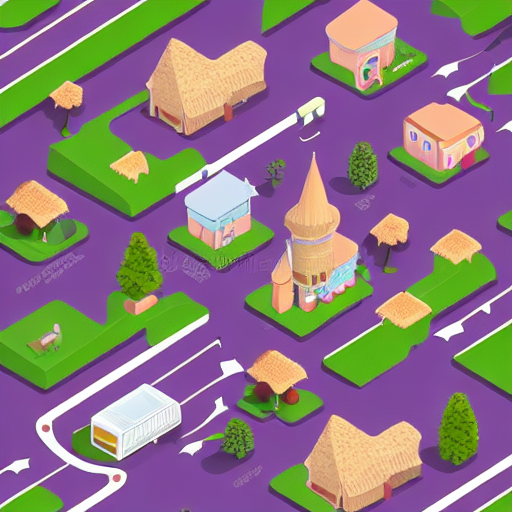

Saved: /content/outputs/batch_2.png


In [4]:
prompts = [
    "a futuristic city skyline at dawn, volumetric light, highly detailed",
    "a macro shot of a dew-covered leaf, photorealistic, shallow depth of field",
    "a whimsical isometric village, pastel palette, cozy atmosphere"
]

images = pipe(
    prompt=prompts,
    negative_prompt=["low quality, blurry"] * len(prompts),
    num_inference_steps=30,
    guidance_scale=7.5
).images

for i, img in enumerate(images):
    path = f"/content/outputs/batch_{i}.png"
    img.save(path)
    display(img)
    print("Saved:", path)
